In [474]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression


from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import spearmanr

import statsmodels.api as sm




## Read the data

In [475]:
data = pd.read_csv('spotify-2023.csv', encoding='latin-1')
data.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


In [476]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    object
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      903 non-null    object
 14  bpm                   953 non-null    int64 
 15  key                   858 non-null    ob

In [477]:
# Conversion des colonnes 'streams', 'in_deezer_playlists' et 'in_shazam_charts' en type numérique
data['streams'] = pd.to_numeric(data['streams'], errors='coerce')
data['in_deezer_playlists'] = pd.to_numeric(data['in_deezer_playlists'], errors='coerce')
data['in_shazam_charts'] = pd.to_numeric(data['in_shazam_charts'], errors='coerce')

# Vérifier les valeurs manquantes
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])

# Remplir ou supprimer les valeurs manquantes
data.fillna(0, inplace=True)  # Exemple : remplir les valeurs manquantes avec 0

# Vérifier les types de données après conversion
print(data.dtypes)


streams                 1
in_deezer_playlists    79
in_shazam_charts       57
key                    95
dtype: int64
track_name               object
artist(s)_name           object
artist_count              int64
released_year             int64
released_month            int64
released_day              int64
in_spotify_playlists      int64
in_spotify_charts         int64
streams                 float64
in_apple_playlists        int64
in_apple_charts           int64
in_deezer_playlists     float64
in_deezer_charts          int64
in_shazam_charts        float64
bpm                       int64
key                      object
mode                     object
danceability_%            int64
valence_%                 int64
energy_%                  int64
acousticness_%            int64
instrumentalness_%        int64
liveness_%                int64
speechiness_%             int64
dtype: object


## 858 lignes pour key et 903 lignes pour in_shazam_charts

In [478]:
df_key = data[data['in_shazam_charts'].notnull()]
data = df_key[df_key['key'].notnull()]
data.loc[:, 'mode'] = [0 if x == 'Minor' else 1 for x in data['mode']]

key_mapping = {
    'A#': 'A',
    'C#': 'C',
    'D#': 'D',
    'F#': 'F',
    'G#': 'G'
}
#data.loc[:, 'key_merged'] = data['key'].replace(key_mapping)

## Distribution of the streams

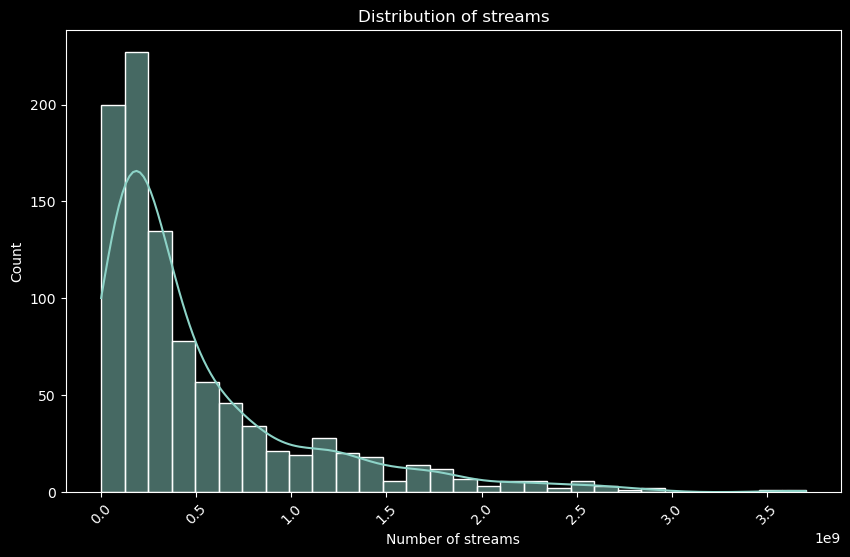

In [479]:
plt.figure(figsize=(10, 6))
sns.histplot(data['streams'], bins=30, kde=True)
plt.xlabel('Number of streams')
plt.ylabel('Count')
plt.title('Distribution of streams')
plt.xticks(rotation=45) 
plt.show()

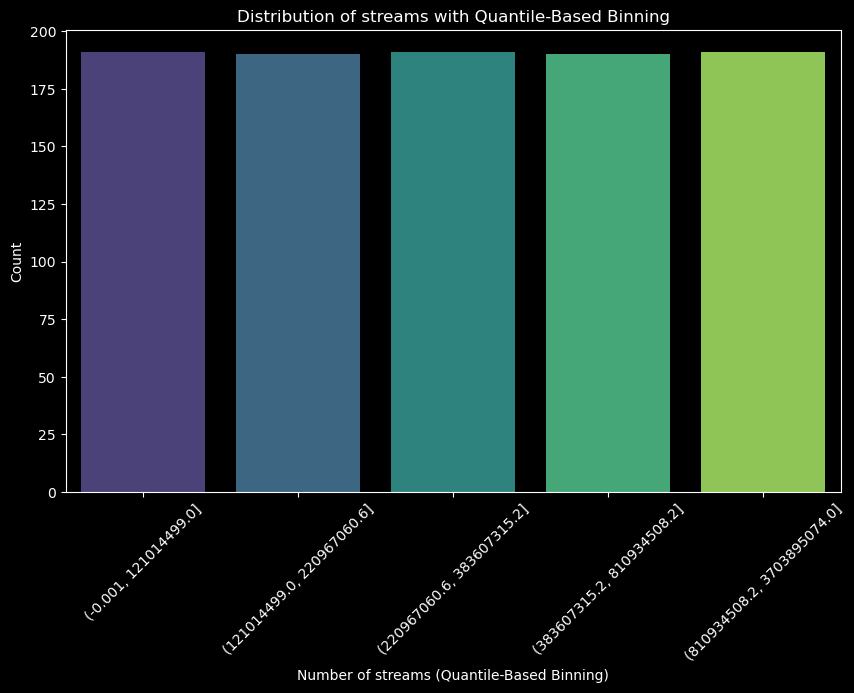

In [480]:
df = data.copy()
num_bins = 5
df['streams_class_quantile'] = pd.qcut(df['streams'], q=num_bins)

# Create a count plot for quantile-based binning
plt.figure(figsize=(10, 6))
sns.countplot(x='streams_class_quantile', data=df, palette='viridis')
plt.xlabel('Number of streams (Quantile-Based Binning)')
plt.ylabel('Count')
plt.title('Distribution of streams with Quantile-Based Binning')
plt.xticks(rotation=45)
plt.show()

df['streams_class'] = pd.qcut(df['streams'], q=num_bins, labels=[f'Class {i+1}' for i in range(num_bins)])

In [481]:
#data['decade'] = data['released_year'].apply(lambda year: (year // 10) * 10)
#data['decade'] = pd.to_numeric(data['decade'])

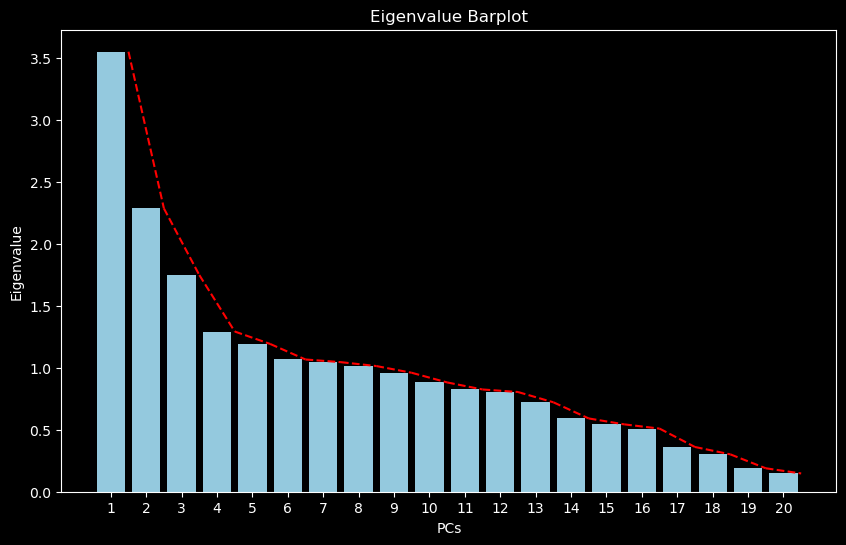

In [482]:
numerical_df = data.select_dtypes(include=['int64', 'float64'])

# Standardize the data (Z = (X - mean)/sd)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_df)

# Perform PCA
pca = PCA()
pca.fit(scaled_data)

# Get the eigenvalues
eigenvalues = pca.explained_variance_
# Plot the eigenvalues
plt.figure(figsize=(10, 6))
sns.barplot(x=np.arange(1, len(eigenvalues) + 1), y=eigenvalues, color='skyblue')
plt.xlabel('PCs')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalue Barplot')
for i in range(len(eigenvalues) - 1):
    plt.plot([i + 0.5, i + 1.5], [eigenvalues[i], eigenvalues[i + 1]], color='red', linestyle='--')
plt.show()

## PCA sur la bpm_class ne donne rien. On fait sur les streams à la place

In [483]:
pca_data = pca.transform(scaled_data)
pca_df = pd.DataFrame(data=pca_data[:, :3], columns=['PC1', 'PC2', 'PC3'])
pca_df['decade'] = data['released_year'].apply(lambda year: (year // 10) * 10)
pca_df['decade'] = pd.to_numeric(pca_df['decade'])
pca = PCA(n_components=3)
pca_result = pca.fit_transform(scaled_data)

In [484]:
print(len(data.columns))

24


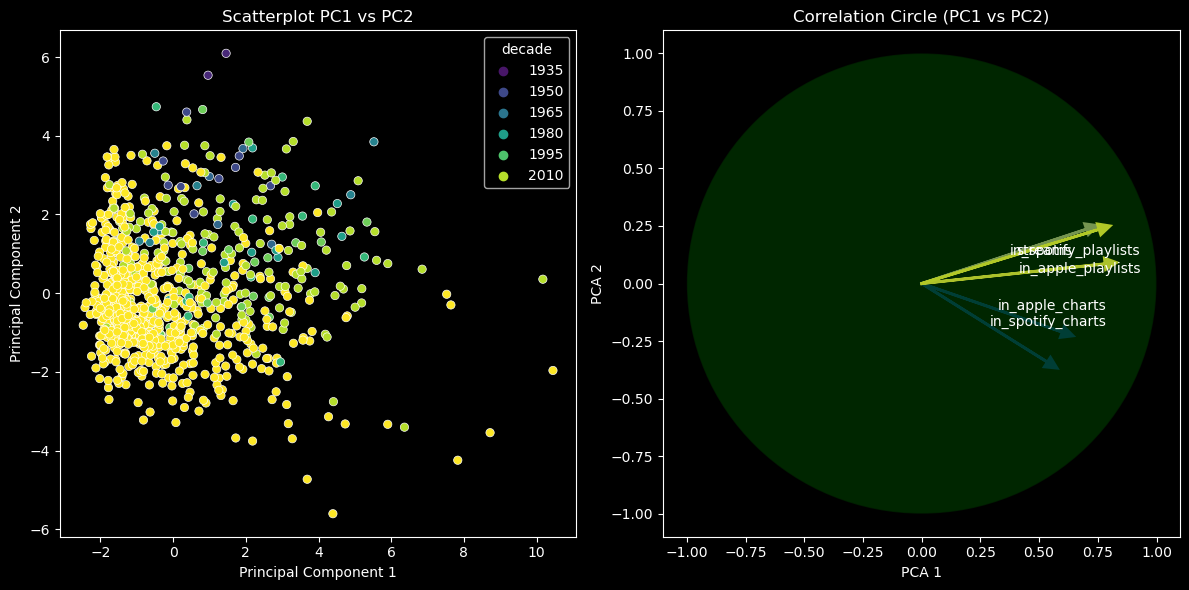

In [485]:
ccircle = []
eucl_dist = []
for j in scaled_data.T:
    corr1 = np.corrcoef(j, pca_result[:, 0])[0, 1]
    corr3 = np.corrcoef(j, pca_result[:, 1])[0, 1]
    ccircle.append((corr1, corr3))
    eucl_dist.append(np.sqrt(corr1**2 + corr3**2))

# Convertir ccircle en un tableau numpy pour faciliter la manipulation
ccircle = np.array(ccircle)

# Convertir eucl_dist en un tableau numpy pour faciliter la manipulation
eucl_dist = np.array(eucl_dist)

# Obtenir les indices des 5 plus grandes contributions
top_indices = np.argsort(eucl_dist)[-5:]

# Garder uniquement les 5 variables les plus contributives
ccircle_top = ccircle[top_indices]
eucl_dist_top = eucl_dist[top_indices]
top_vars = [numerical_df.columns[i] for i in top_indices]


# Convertir ccircle en un tableau numpy pour faciliter la manipulation
ccircle = np.array(ccircle)

# Afficher les graphiques côte à côte
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Premier graphique : Scatterplot PC1 vs PC2
sns.scatterplot(x='PC1', y='PC2', hue='decade', data=pca_df, ax=axs[0], palette = 'viridis')
axs[0].set_xlabel('Principal Component 1')
axs[0].set_ylabel('Principal Component 2')
axs[0].set_title('Scatterplot PC1 vs PC2')

# Deuxième graphique : Correlation Circle PC1 vs PC3
for i, j in enumerate(eucl_dist_top):
    arrow_col = plt.cm.cividis((j - np.array(eucl_dist_top).min()) / (np.array(eucl_dist_top).max() - np.array(eucl_dist_top).min()))
    axs[1].arrow(0, 0,  # Arrows start at the origin
                 ccircle_top[i][0],  # 0 for PC1
                 ccircle_top[i][1],  # 1 fr PC2
                 lw=2,  # line width
                 length_includes_head=True,
                 color=arrow_col,
                 fc=arrow_col,
                 head_width=0.05,
                 head_length=0.05)
    axs[1].text(ccircle_top[i][0] / 2, ccircle_top[i][1] / 2, top_vars[i])
# Draw the unit circle, for clarity
circle = Circle((0, 0), 1, facecolor='green', edgecolor='k', linewidth=1, alpha=0.3)
axs[1].add_patch(circle)
axs[1].set_xlabel("PCA 1")
axs[1].set_ylabel("PCA 2")
axs[1].set_title('Correlation Circle (PC1 vs PC2)')

plt.tight_layout()
plt.show()

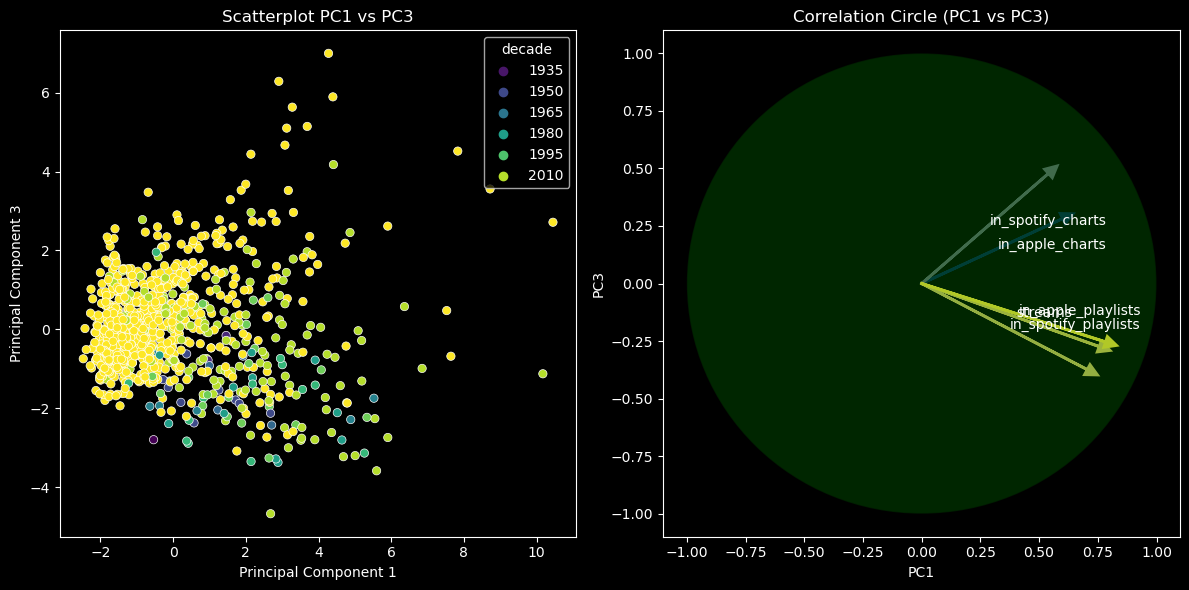

In [486]:
ccircle = []
eucl_dist = []
for j in scaled_data.T:
    corr1 = np.corrcoef(j, pca_result[:, 0])[0, 1]
    corr3 = np.corrcoef(j, pca_result[:, 2])[0, 1]
    ccircle.append((corr1, corr3))
    eucl_dist.append(np.sqrt(corr1**2 + corr3**2))

# Convertir ccircle en un tableau numpy pour faciliter la manipulation
ccircle = np.array(ccircle)

# Convertir eucl_dist en un tableau numpy pour faciliter la manipulation
eucl_dist = np.array(eucl_dist)

# Obtenir les indices des 5 plus grandes contributions
top_indices = np.argsort(eucl_dist)[-5:]

# Garder uniquement les 5 variables les plus contributives
ccircle_top = ccircle[top_indices]
eucl_dist_top = eucl_dist[top_indices]
top_vars = [numerical_df.columns[i] for i in top_indices]


# Convertir ccircle en un tableau numpy pour faciliter la manipulation
ccircle = np.array(ccircle)

# Afficher les graphiques côte à côte
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Premier graphique : Scatterplot PC1 vs PC2
sns.scatterplot(x='PC1', y='PC3', hue='decade', data=pca_df, ax=axs[0], palette = 'viridis')
axs[0].set_xlabel('Principal Component 1')
axs[0].set_ylabel('Principal Component 3')
axs[0].set_title('Scatterplot PC1 vs PC3')

# Deuxième graphique : Correlation Circle PC1 vs PC3
for i, j in enumerate(eucl_dist_top):
    arrow_col = plt.cm.cividis((j - np.array(eucl_dist_top).min()) / (np.array(eucl_dist_top).max() - np.array(eucl_dist_top).min()))
    axs[1].arrow(0, 0,  # Arrows start at the origin
                 ccircle_top[i][0],  # 0 for PC1
                 ccircle_top[i][1],  # 1 fr PC2
                 lw=2,  # line width
                 length_includes_head=True,
                 color=arrow_col,
                 fc=arrow_col,
                 head_width=0.05,
                 head_length=0.05)
    axs[1].text(ccircle_top[i][0] / 2, ccircle_top[i][1] / 2, top_vars[i])
# Draw the unit circle, for clarity
circle = Circle((0, 0), 1, facecolor='green', edgecolor='k', linewidth=1, alpha=0.3)
axs[1].add_patch(circle)
axs[1].set_xlabel("PC1")
axs[1].set_ylabel("PC3")
axs[1].set_title('Correlation Circle (PC1 vs PC3)')

plt.tight_layout()
plt.show()

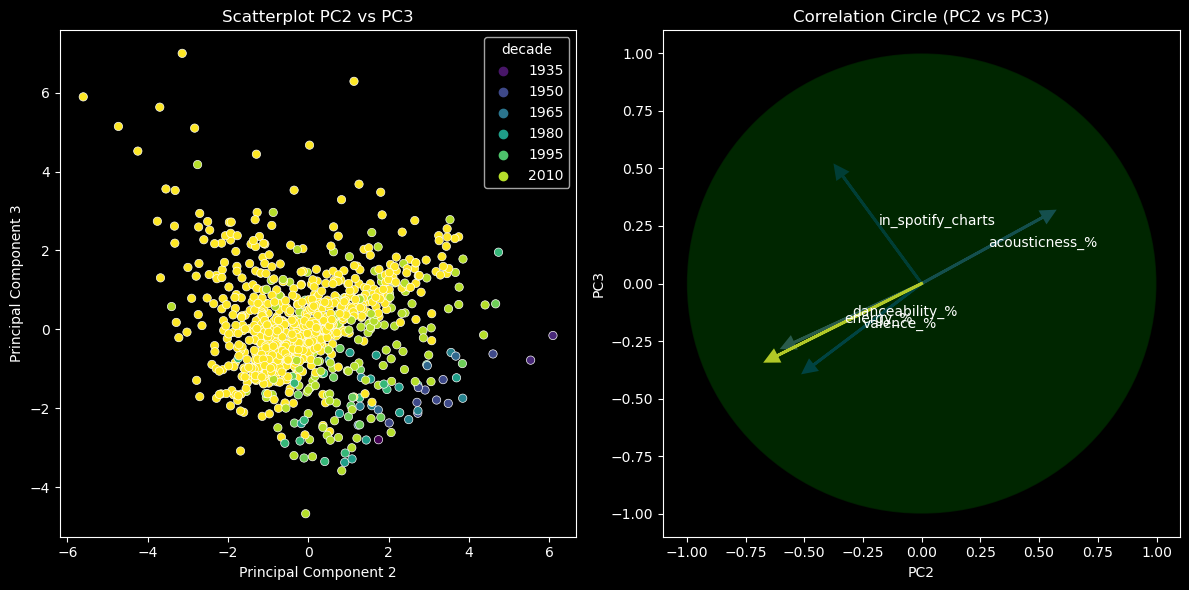

In [487]:
ccircle = []
eucl_dist = []
for j in scaled_data.T:
    corr1 = np.corrcoef(j, pca_result[:, 1])[0, 1]
    corr3 = np.corrcoef(j, pca_result[:, 2])[0, 1]
    ccircle.append((corr1, corr3))
    eucl_dist.append(np.sqrt(corr1**2 + corr3**2))

# Convertir ccircle en un tableau numpy pour faciliter la manipulation
ccircle = np.array(ccircle)

# Convertir eucl_dist en un tableau numpy pour faciliter la manipulation
eucl_dist = np.array(eucl_dist)

# Obtenir les indices des 5 plus grandes contributions
top_indices = np.argsort(eucl_dist)[-5:]

# Garder uniquement les 5 variables les plus contributives
ccircle_top = ccircle[top_indices]
eucl_dist_top = eucl_dist[top_indices]
top_vars = [numerical_df.columns[i] for i in top_indices]


# Convertir ccircle en un tableau numpy pour faciliter la manipulation
ccircle = np.array(ccircle)

# Afficher les graphiques côte à côte
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Premier graphique : Scatterplot PC1 vs PC2
sns.scatterplot(x='PC2', y='PC3', hue='decade', data=pca_df, ax=axs[0], palette = 'viridis')
axs[0].set_xlabel('Principal Component 2')
axs[0].set_ylabel('Principal Component 3')
axs[0].set_title('Scatterplot PC2 vs PC3')

# Deuxième graphique : Correlation Circle PC1 vs PC3
for i, j in enumerate(eucl_dist_top):
    arrow_col = plt.cm.cividis((j - np.array(eucl_dist_top).min()) / (np.array(eucl_dist_top).max() - np.array(eucl_dist_top).min()))
    axs[1].arrow(0, 0,  # Arrows start at the origin
                 ccircle_top[i][0],  # 0 for PC1
                 ccircle_top[i][1],  # 1 fr PC2
                 lw=2,  # line width
                 length_includes_head=True,
                 color=arrow_col,
                 fc=arrow_col,
                 head_width=0.05,
                 head_length=0.05)
    axs[1].text(ccircle_top[i][0] / 2, ccircle_top[i][1] / 2, top_vars[i])
# Draw the unit circle, for clarity
circle = Circle((0, 0), 1, facecolor='green', edgecolor='k', linewidth=1, alpha=0.3)
axs[1].add_patch(circle)
axs[1].set_xlabel("PC2")
axs[1].set_ylabel("PC3")
axs[1].set_title('Correlation Circle (PC2 vs PC3)')

plt.tight_layout()
plt.show()

In [488]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init=10, random_state=8)
    kmeans.fit(numerical_df)
    wcss.append(kmeans.inertia_)

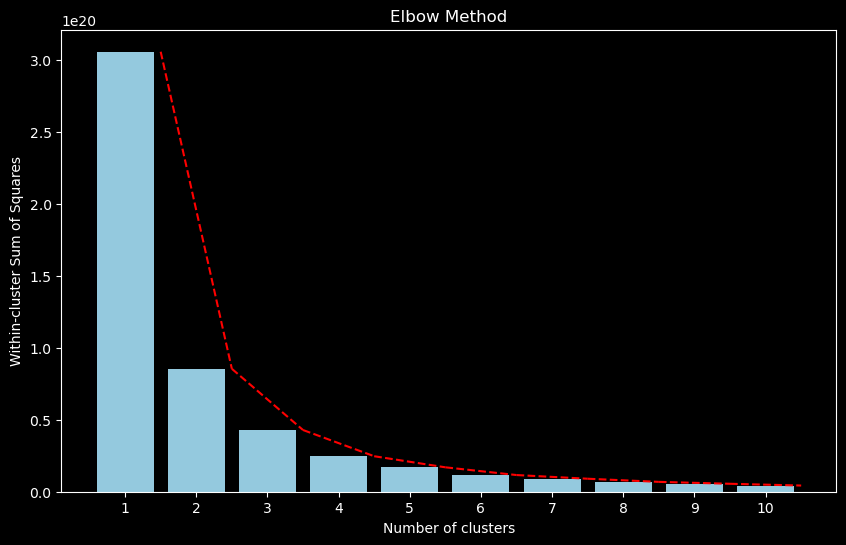

In [489]:
plt.figure(figsize=(10, 6))
sns.barplot(x=np.arange(1, len(wcss) +1), y=wcss, color="skyblue")
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster Sum of Squares')
for i in range(len(wcss) - 1):
    plt.plot([i + 0.5, i + 1.5], [wcss[i], wcss[i + 1]], color='red', linestyle='--')
plt.show()

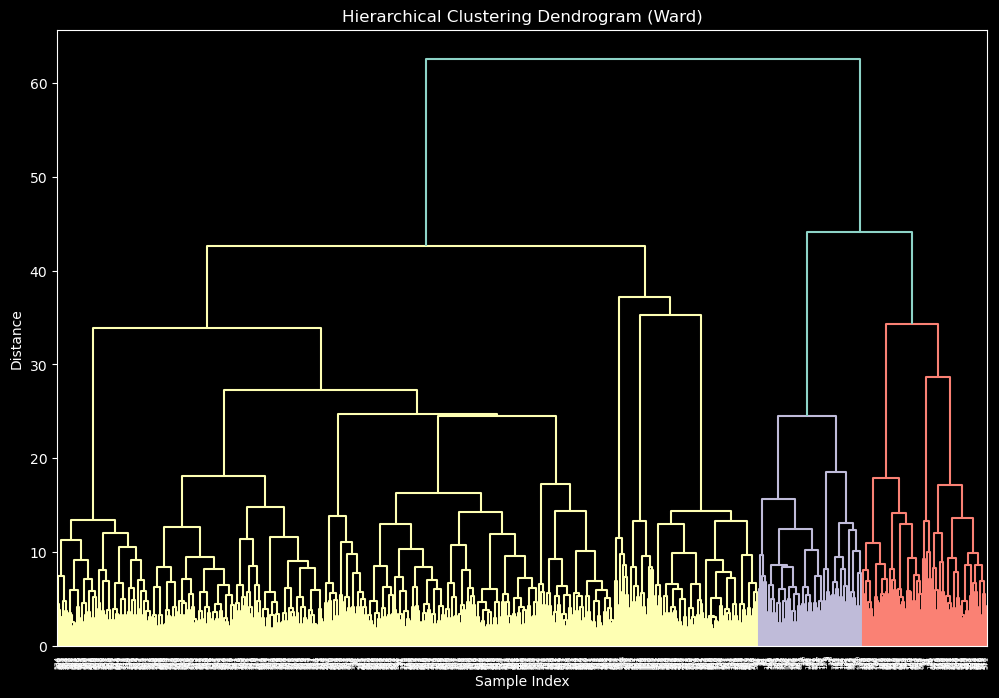

In [490]:
plt.figure(figsize=(12, 8))
dendrogram(linkage(scaled_data, method = 'ward'))
plt.title('Hierarchical Clustering Dendrogram (Ward)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [491]:
pca = PCA(n_components=3)
pca.fit(numerical_df)

# Get the principal components
components = pca.components_

# Create a DataFrame for better readability
components_df = pd.DataFrame(components, columns=numerical_df.columns, index=['PC1', 'PC2', 'PC3'])
# Get the most important columns for each PC
def get_most_principal_columns(components_df, n_top=3):
    most_principal_columns = {}
    for pc in components_df.index:
        most_principal_columns[pc] = components_df.loc[pc].abs().nlargest(n_top).index.tolist()
    return most_principal_columns

most_principal_columns = get_most_principal_columns(components_df)
print("\nMost Principal Columns:\n", most_principal_columns)


Most Principal Columns:
 {'PC1': ['streams', 'in_spotify_playlists', 'in_deezer_playlists'], 'PC2': ['in_spotify_playlists', 'in_deezer_playlists', 'in_shazam_charts'], 'PC3': ['in_deezer_playlists', 'in_shazam_charts', 'in_apple_playlists']}


In [492]:
kmeans = KMeans(n_clusters=2, random_state=8)
kmeans.fit(numerical_df)

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

# Create a DataFrame for better readability
cluster_centers_df = pd.DataFrame(cluster_centers, columns=numerical_df.columns)

# Get the most important features for each cluster
def get_most_principal_features(cluster_centers_df, n_top=3):
    most_principal_features = {}
    for cluster in cluster_centers_df.index:
        most_principal_features[f'Cluster {cluster}'] = cluster_centers_df.loc[cluster].nlargest(n_top).index.tolist()
    return most_principal_features

most_principal_features = get_most_principal_features(cluster_centers_df)
print("\nMost Principal Features:\n", most_principal_features)


Most Principal Features:
 {'Cluster 0': ['streams', 'in_spotify_playlists', 'released_year'], 'Cluster 1': ['streams', 'in_spotify_playlists', 'released_year']}


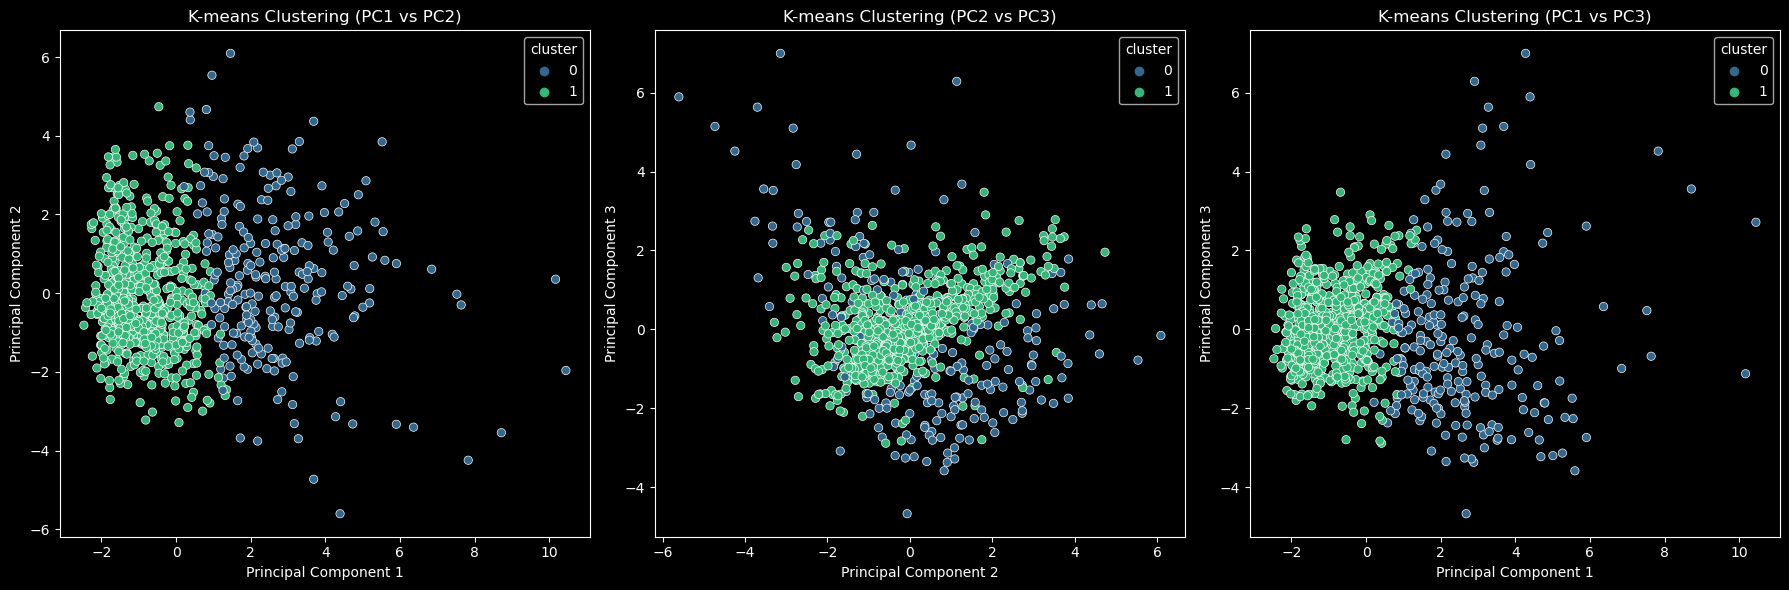

In [493]:
kmeans = KMeans(n_clusters=2, random_state=8)
kmeans.fit(scaled_data)

# Add cluster labels to the DataFrame
pca_df['cluster'] = kmeans.labels_

# Affichage des graphiques côte à côte
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Scatterplot PC1 vs PC2
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, ax=axs[0], palette='viridis')
axs[0].set_title('K-means Clustering (PC1 vs PC2)')
axs[0].set_xlabel('Principal Component 1')
axs[0].set_ylabel('Principal Component 2')

# Scatterplot PC2 vs PC3
sns.scatterplot(x='PC2', y='PC3', hue='cluster', data=pca_df, ax=axs[1], palette='viridis')
axs[1].set_title('K-means Clustering (PC2 vs PC3)')
axs[1].set_xlabel('Principal Component 2')
axs[1].set_ylabel('Principal Component 3')

# Scatterplot PC1 vs PC3
sns.scatterplot(x='PC1', y='PC3', hue='cluster', data=pca_df, ax=axs[2], palette='viridis')
axs[2].set_title('K-means Clustering (PC1 vs PC3)')
axs[2].set_xlabel('Principal Component 1')
axs[2].set_ylabel('Principal Component 3')

plt.tight_layout()
plt.show()

# Finding a predictive variable

In [494]:
# Create a new DataFrame with relevant columns
relevant_columns = ['streams', 'bpm', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%', 'in_spotify_playlists', 'in_spotify_charts', 'in_apple_playlists', 'in_deezer_playlists', 'in_shazam_charts']
df_relevant = data[relevant_columns].copy()
# Convert 'streams' and other relevant columns to numeric
df_relevant['streams'] = pd.to_numeric(df_relevant['streams'], errors='coerce')
df_relevant['in_deezer_playlists'] = pd.to_numeric(df_relevant['in_deezer_playlists'], errors='coerce')
df_relevant['in_shazam_charts'] = pd.to_numeric(df_relevant['in_shazam_charts'], errors='coerce')


# Drop rows with missing values in relevant columns
df_relevant = df_relevant.dropna()
# Define the independent variables (X) and the dependent variable (y)
X = df_relevant[['bpm', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%', 'in_spotify_playlists', 'in_spotify_charts', 'in_apple_playlists', 'in_deezer_playlists', 'in_shazam_charts']]
y = df_relevant['streams']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the multiple linear regression model
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                streams   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     215.2
Date:                Thu, 06 Jun 2024   Prob (F-statistic):          9.65e-271
Time:                        01:25:13   Log-Likelihood:                -19902.
No. Observations:                 953   AIC:                         3.983e+04
Df Residuals:                     939   BIC:                         3.990e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.523e+08 

In [495]:
def calculate_and_plot_correlation(df, col1, col2, plot=True):
    
    # Calculate the correlation
    correlation, p_value = spearmanr(df[col1], df[col2])
    
    # Print the correlation coefficient
    print(f"Spearman correlation between {col1} and {col2}: {correlation}, p_value: {p_value}")
    
    # Optionally plot the data
    if plot:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=df, x=col1, y=col2)
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.title(f'Spearman correlation between {col1} and {col2}')
        plt.show()
    
    return correlation


Spearman correlation between streams and in_spotify_playlists: 0.8301377389710216, p_value: 1.6424501433362207e-243


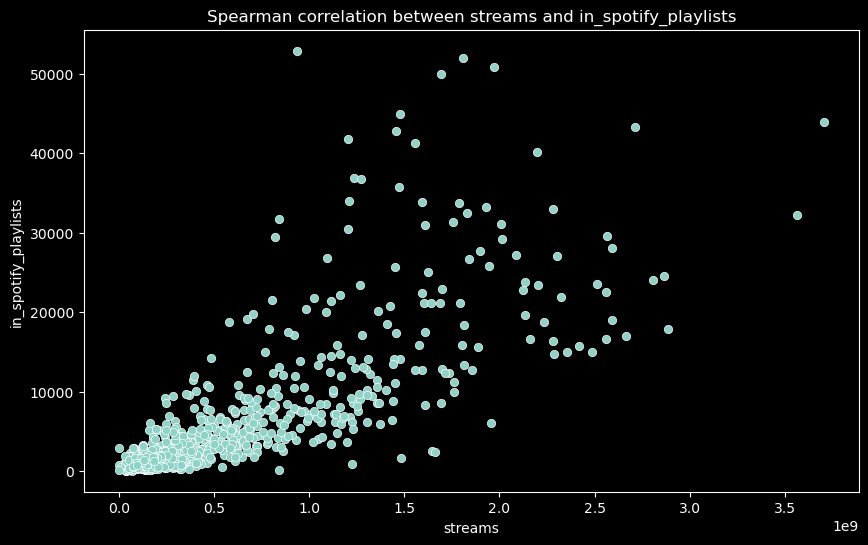

In [496]:
# Example usage:
correlation = calculate_and_plot_correlation(data, 'streams', 'in_spotify_playlists', True)

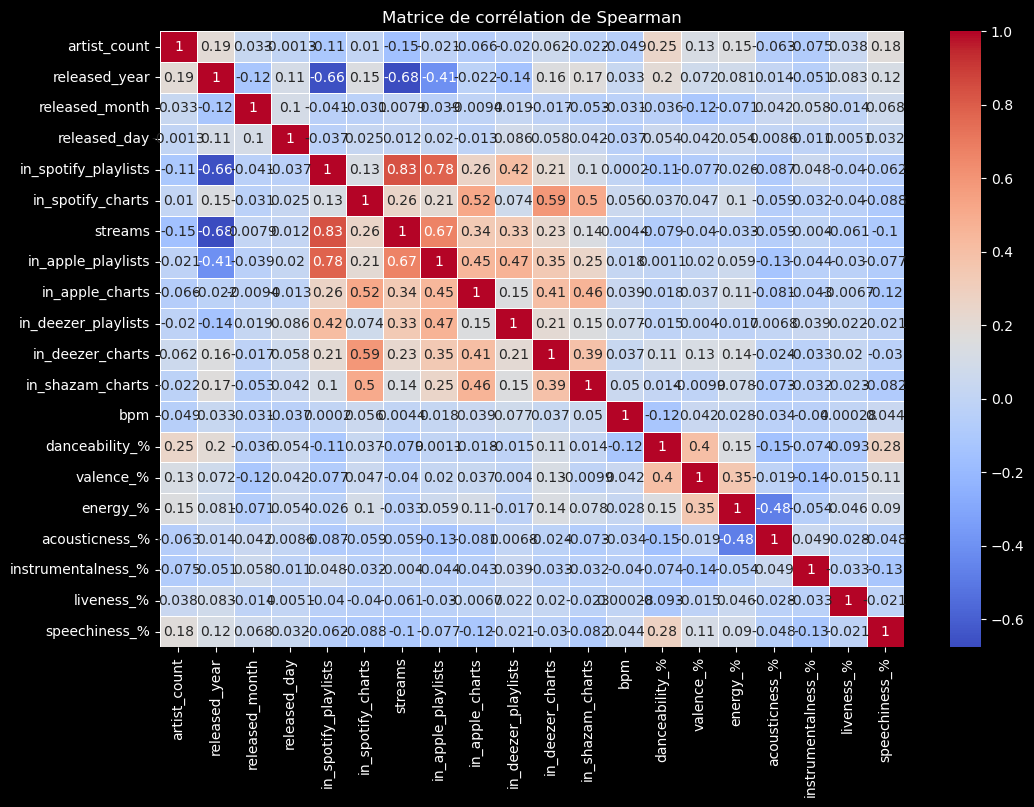

In [497]:
def compute_spearman_correlation_matrix(df):
    # Sélectionner uniquement les colonnes de type int64
    int_df = df.select_dtypes(include=['int64', 'float64'])
    
    # Calculer la matrice de corrélation de Spearman
    spearman_correlation_matrix = int_df.corr(method='spearman')
    
    return spearman_correlation_matrix

spearman_correlation_matrix = compute_spearman_correlation_matrix(data)


plt.figure(figsize=(12, 8))
sns.heatmap(spearman_correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Matrice de corrélation de Spearman')
plt.show()


## Correlation between Variables ##

1. (streams, in_spotify_playlists): **0.83**
2. (in_spotify_playlists, in_apple_playlists): **0.78**
3. (streams, in_apple_playlists): **0.67**
4. (streams, released_year): **-0.68**
5. (released_year, in_spotify_playlists): **-0.66**


/Users/azmanizakary/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


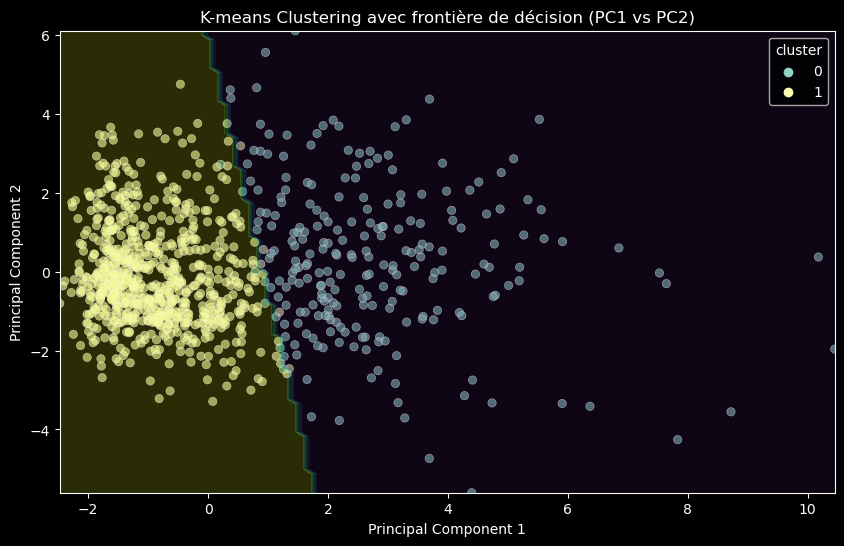

[4.71894167]
[[-5.08469888 -0.78486076]]


In [498]:
# Sélectionner les colonnes numériques
numerical_df = df.select_dtypes(include=['int64', 'float64'])

# Normaliser les données
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_df)

# Appliquer l'ACP
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Créer un DataFrame pour les résultats de l'ACP
pca_df2 = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

# Appliquer le K-means
kmeans = KMeans(n_clusters=2, random_state=8)
kmeans.fit(scaled_data)

# Ajouter les labels des clusters au DataFrame
pca_df2['cluster'] = kmeans.labels_

# Appliquer la régression logistique
log_reg = LogisticRegression()
log_reg.fit(pca_df2[['PC1', 'PC2']], pca_df2['cluster'])

# Visualiser les clusters et la frontière de décision
plt.figure(figsize=(10, 6))

# Plot des points
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df2, alpha=0.6)

# Création d'un maillage pour les prédictions
xx, yy = np.meshgrid(np.linspace(pca_df2['PC1'].min(), pca_df2['PC1'].max(), 100),
                     np.linspace(pca_df2['PC2'].min(), pca_df2['PC2'].max(), 100))

# Prédictions sur le maillage
Z = log_reg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Tracer la frontière de décision
plt.contourf(xx, yy, Z, alpha=0.2)

plt.title('K-means Clustering avec frontière de décision (PC1 vs PC2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

print(log_reg.intercept_)
print(log_reg.coef_)